# Imports

In [1]:
import json
import requests

from datetime import datetime

import pandas as pd
import numpy as np
from geopy.distance import distance

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from typing import List, Union

# Query GraphQL

In [2]:
def query_graphql(start_time: int, end_time: int, route: str) -> list:
    query = f"""{{
        trynState(agency: "muni",
                  startTime: "{start_time}",
                  endTime: "{end_time}",
                  routes: ["{route}"]) {{
            agency
            startTime
            routes {{
                stops {{
                    sid
                    lat
                    lon
                }}
                routeStates {{
                    vtime
                    vehicles {{
                        vid
                        lat
                        lon
                        did
                    }}
                }}
            }}
        }}
    }}
    """
    query_url = f"https://06o8rkohub.execute-api.us-west-2.amazonaws.com/dev/graphql?query={query}"

    request = requests.get(query_url).json()
    try:
        return request['data']['trynState']['routes']
    except KeyError:
        return None

# Produce Datatables

In [3]:
def produce_stops(data: list) -> pd.DataFrame:
    stops = pd.io.json.json_normalize(data,
                                      record_path=['stops']) \
            .rename(columns={'lat': 'LAT',
                             'lon': 'LON',
                             'sid': 'SID'}) \
            .reindex(['SID', 'LAT', 'LON'], axis='columns')
    
    # obtain stop directions
    stops['DID'] = stops['SID'].map({stop: direction['id']
                                     for direction in requests
                                                      .get("http://restbus.info/api/agencies/sf-muni/"
                                                           f"routes/{route}")
                                                      .json()['directions']
                                     for stop in direction['stops']})
    
    # remove stops that don't have an associated direction
    stops = stops.dropna(axis='index', subset=['DID'])
    
    # obtain stop ordinals
    stops['ORD'] = stops['SID'].map({stop_meta['id']: ordinal
                                     for ordinal, stop_meta
                                     in enumerate(requests
                                                  .get("http://restbus.info/api/agencies/sf-muni/"
                                                       f"routes/{route}")
                                                  .json()['stops'])})
    
    return stops

In [4]:
def produce_buses(data: list) -> pd.DataFrame:
     return pd.io.json.json_normalize(data,
                                      record_path=['routeStates', 'vehicles'],
                                      meta=[['routeStates', 'vtime']]) \
            .rename(columns={'lat': 'LAT',
                             'lon': 'LON',
                             'vid': 'VID',
                             'did': 'DID',
                             'routeStates.vtime': 'TIME'}) \
            .reindex(['TIME', 'VID', 'LAT', 'LON', 'DID'], axis='columns')

# Eclipses

In [5]:
def find_eclipses(buses, stop):
    """
    Find movement of buses relative to the stop, in distance as a function of time.
    """
    def split_eclipses(eclipses, threshold=30*60*1000) -> List[pd.DataFrame]:
        """
        Split buses' movements when they return to a stop after completing the route.
        """
        disjoint_eclipses = []
        for bus_id in eclipses['VID'].unique():
            # obtain distance data for this bus
            bus = eclipses[eclipses['VID'] == bus_id].sort_values('TIME')

            # split data into groups when there is at least a `threshold`-ms gap between data points
            group_ids = (bus['TIME'] > (bus['TIME'].shift() + threshold)).cumsum()

            # store groups
            for _, group in bus.groupby(group_ids):
                disjoint_eclipses.append(group)
        return disjoint_eclipses

    eclipses = buses.copy()
    
    eclipses['DIST'] = eclipses.apply(lambda bus: distance(stop[['LAT', 'LON']],
                                                           bus[['LAT', 'LON']]).meters,
                                      axis='columns')
    eclipses['TIME'] = eclipses['TIME'].astype(int)
    eclipses = eclipses[['TIME', 'VID', 'DIST']]
    
    # only keep positions within 750 meters
    eclipses = eclipses[eclipses['DIST'] < 750]
    
    eclipses = split_eclipses(eclipses)
    
    return eclipses

def find_nadirs(eclipses):
    """
    Find points where buses are considered to have encountered the stop.
    
    Nadir is an astronomical term that describes the lowest point reached by an orbiting body.
    """
    def calc_nadir(eclipse: pd.DataFrame) -> Union[pd.Series, None]:
        nadir = eclipse.iloc[eclipse['DIST'].values.argmin()]
        if nadir['DIST'] < 100:  # if min dist < 100, then reasonable candidate for nadir
            return nadir
        else:  # otherwise, hardcore datasci is needed
            rev_eclipse = eclipse.iloc[::-1]
            rev_nadir = rev_eclipse.iloc[rev_eclipse['DIST'].values.argmin()]
            if nadir['TIME'] == rev_nadir['TIME']:  # if eclipse has a global min
                return nadir  # then it's the best candidate for nadir
            else:  # if eclipse's min occurs at two times
                mid_nadir = nadir.copy()
                mid_nadir['DIST'] = (nadir['DIST'] + rev_nadir['DIST'])/2
                return mid_nadir  # take the midpoint of earliest and latest mins
    
    nadirs = []
    for eclipse in eclipses:
        nadirs.append(calc_nadir(eclipse)[['VID', 'TIME']])
        
    return pd.DataFrame(nadirs)
            
    
def show_stop(eclipses, nadirs):
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111)

    for eclipse in eclipses:
        plt.plot(*eclipse[['TIME', 'DIST']].values.T)
        
    for nadir_time in nadirs['TIME']:
        plt.axvline(nadir_time, linestyle='--', linewidth=.5)

    # format plot
    ax.get_xaxis().set_major_formatter(  # convert x-axis tick labels to time of day
        FuncFormatter(lambda x, p: datetime.fromtimestamp(int(x)//1000).strftime('%I:%M%p')))
    plt.title(f"Eclipses at Stop {stop_id}"
              f" from {datetime.fromtimestamp(int(start_time)//1000).strftime('%a %I:%M%p')}"
              f" to {datetime.fromtimestamp(int(end_time)//1000).strftime('%a %I:%M%p')}")
    plt.xlabel("Time")
    plt.ylabel("Distance from Stop (meters)")

    plt.show()

# Hardcore Data Science

In [6]:
route = "14"

timespan = ("08:00 PST",
            "11:00 PST")

dates = [
    "2018-11-12",
    "2018-11-13",
    "2018-11-14",
    "2018-11-15",
    "2018-11-16",

    "2018-11-19",
    "2018-11-20",
    "2018-11-21",
    "2018-11-22",
    "2018-11-23",
]

Issue: The plot is labeled based on the machine's current timezone, which may not necessarily match the times sent to the API. To remedy this, the logic for displaying the plot would have to be adjusted to account for the UTC offset of the epochs we get back from the API, which I'm hoping there's a module for but I'm not presently familiar with any.

Issue: currently, if a trajectory looks like `/~V`, the left edge is selected as the nadir. Based on the data, I suspect that the initial upslope may be a GPS glitch as it's being initialized, I believe the trough on the right should be selected instead.

In [7]:
class BusData:
    def __init__(self):
        self.data = {}
    
    @property
    def routes(self):
        return list(self.data.keys())
    
    @property
    def stops(self, route_id):
        return list(self.data.get(route_id, {}).keys())
    
    def append(self, other_data):
        for route_id, other_route in other_data.items():
            route = self.data.get(route_id)
            if route:
                for stop_id, other_stop in other_route.items():
                    stop = route.get(stop_id)
                    if stop:
                        stop['eclipses'].extend(other_stop['eclipses'])
                    else:
                        route[stop_id] = other_stop
            else:
                self.data[route_id] = other_route
    
    @classmethod
    def read_file(cls, filename):
        bus_data = cls()
        with open(filename, 'r') as f:
            file_data = json.load(f)
        for route in file_data:
            for stop in route['stops']:
                bus_data.append({
                    route['route_id']: {
                        stop['stop_id']: {
                            'direction_id': stop['direction_id'],
                            'order': stop['order'],
                            'lat': stop['lat'],
                            'lon': stop['lon'],
                            'eclipses': stop['eclipses']
                        }
                    }
                })
        return bus_data
                
    
    def write_file(self, filename):
        output = [
            {
                'route_id': route_id,
                'stops': [
                    {
                        'stop_id': stop_id,
                        'direction_id': stop['direction_id'],
                        'order': stop['order'],
                        'lat': stop['lat'],
                        'lon': stop['lon'],
                        'eclipses': stop['eclipses']
                    }
                    for stop_id, stop in route.items()
                ]
            }
            for route_id, route in self.data.items()
        ]
        with open(filename, 'w') as f:
            json.dump(output, f)

`BusData.data` specification:
```
{
    route_id: {  # route_id is a str
        stop_id: {  # stop_id is a str
            direction_id: str,
            order: int,
            lat: float,
            lon: float,
            eclipses: [
                {
                    bus_id: int,
                    timestamp: int,
                },
                {
                    bus_id: int,
                    timestamp: int,
                },
                ...
            ]
        },
        ...
    },
    ...
}
```

data export specification:
```
[
    {
        route_id: str,
        stops: [
            {
                stop_id: str,
                direction_id: str,
                order: int,
                lat: float,
                lon: float,
                eclipses: [
                    {
                        bus_id: int,
                        timestamp: int,
                    },
                    {
                        bus_id: int,
                        timestamp: int,
                    },
                    ...
                ]
            },
            ...
        ]
    },
    ...
]
```

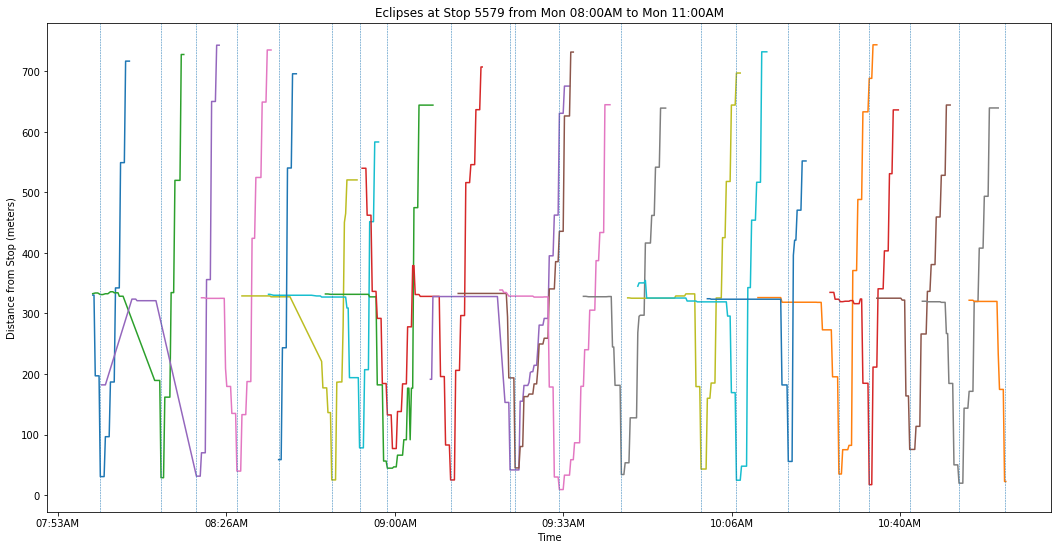

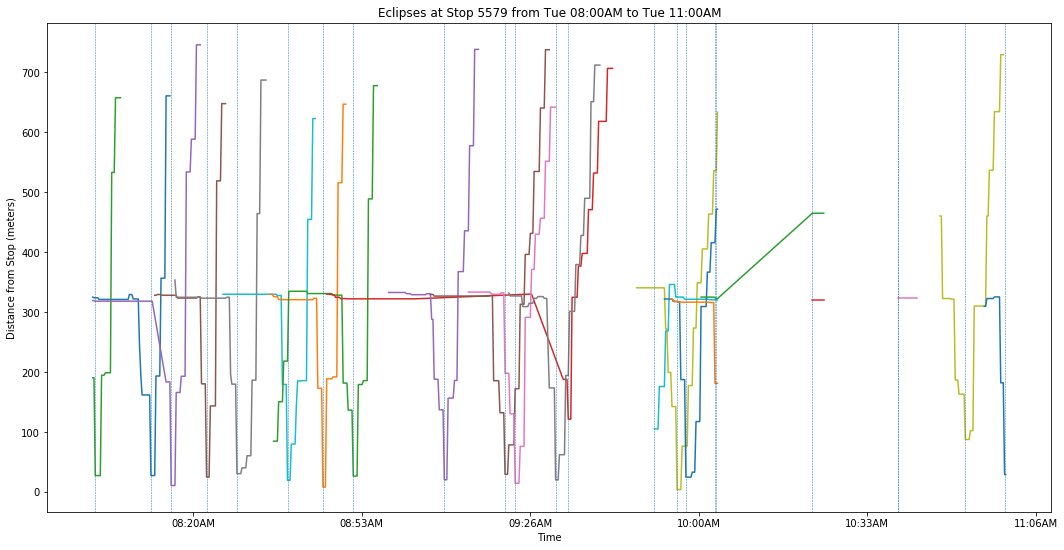

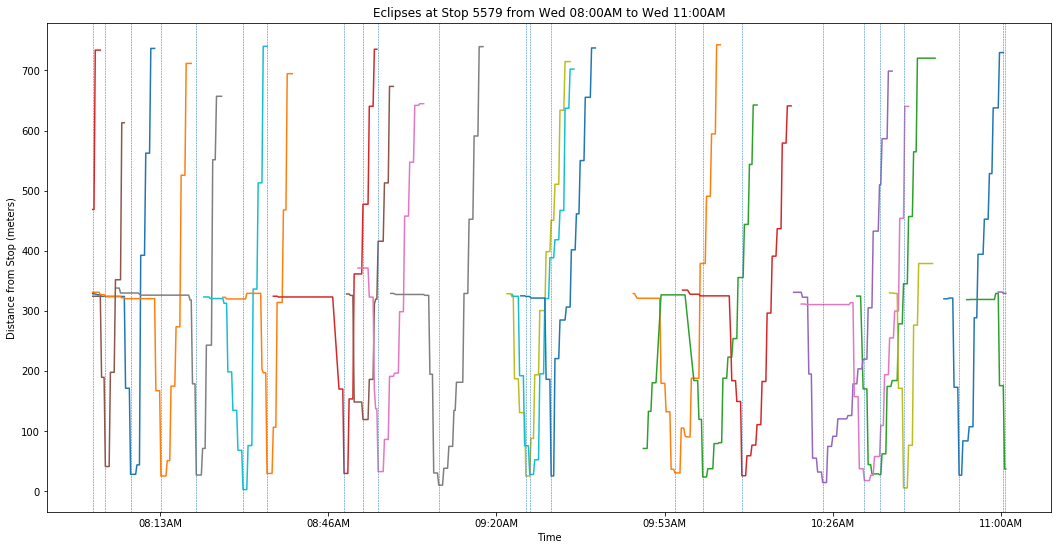

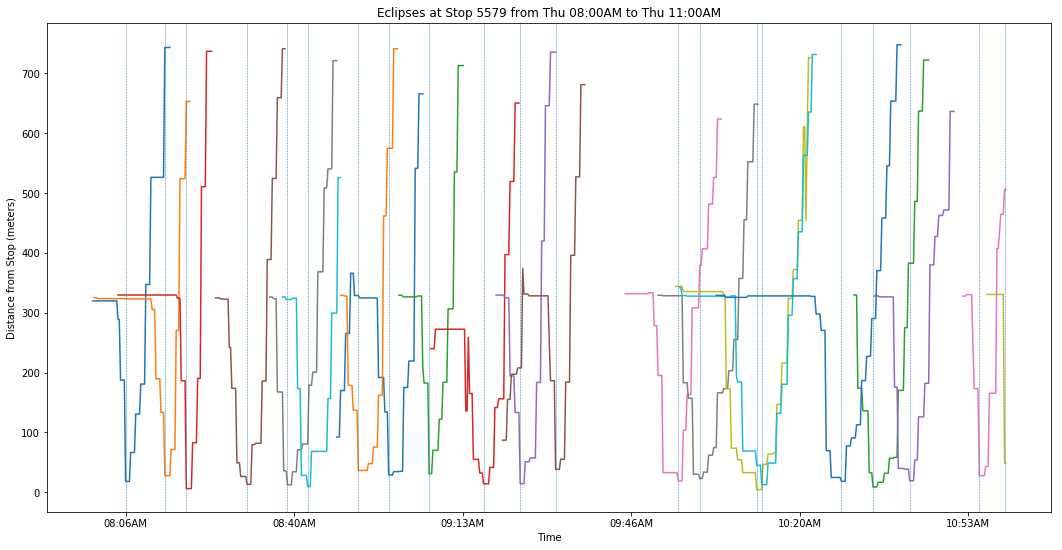

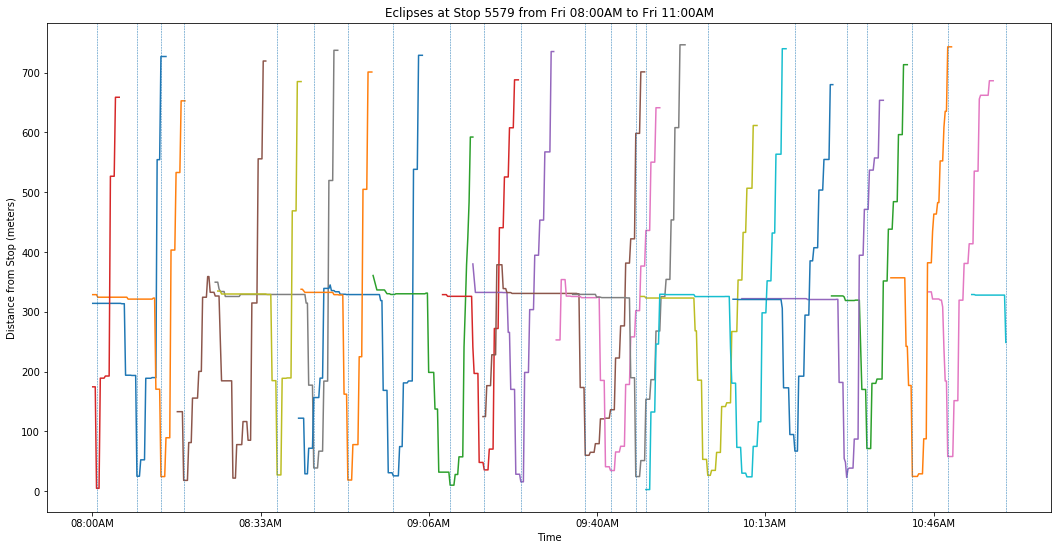

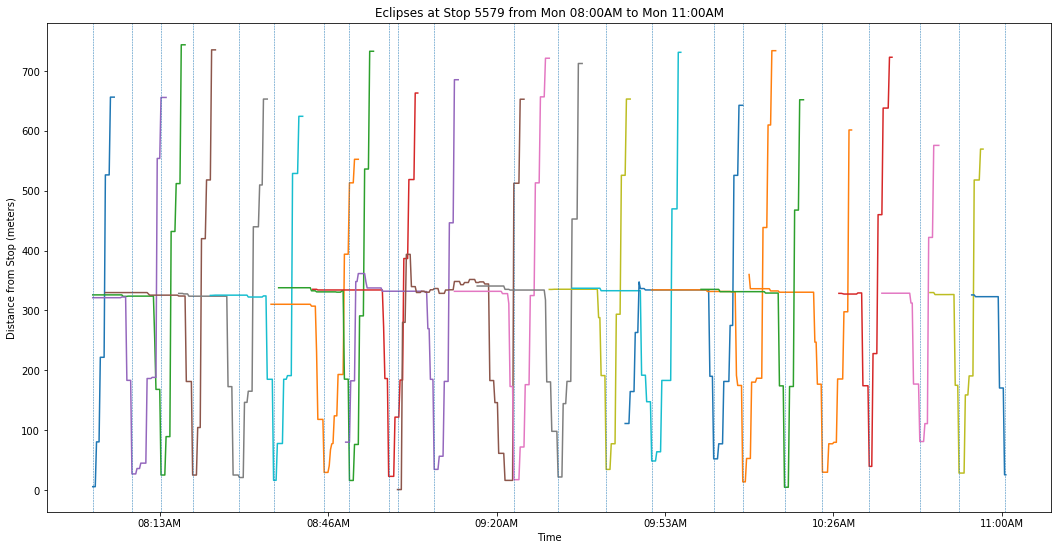

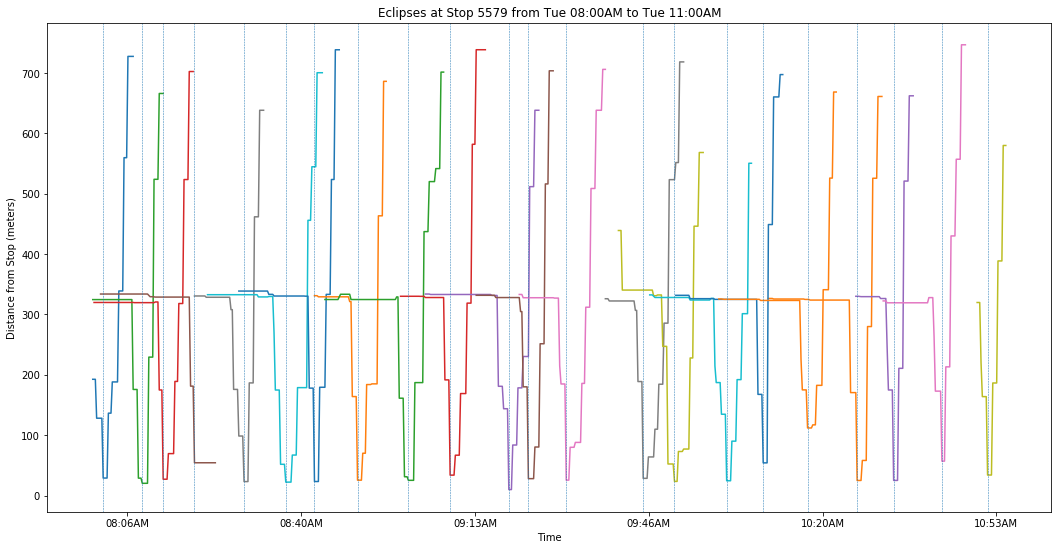

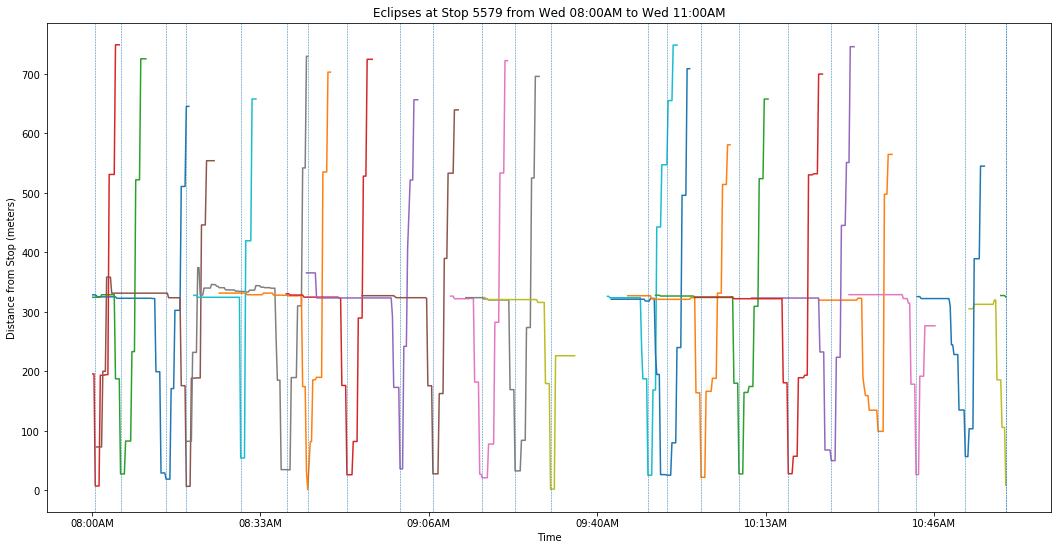

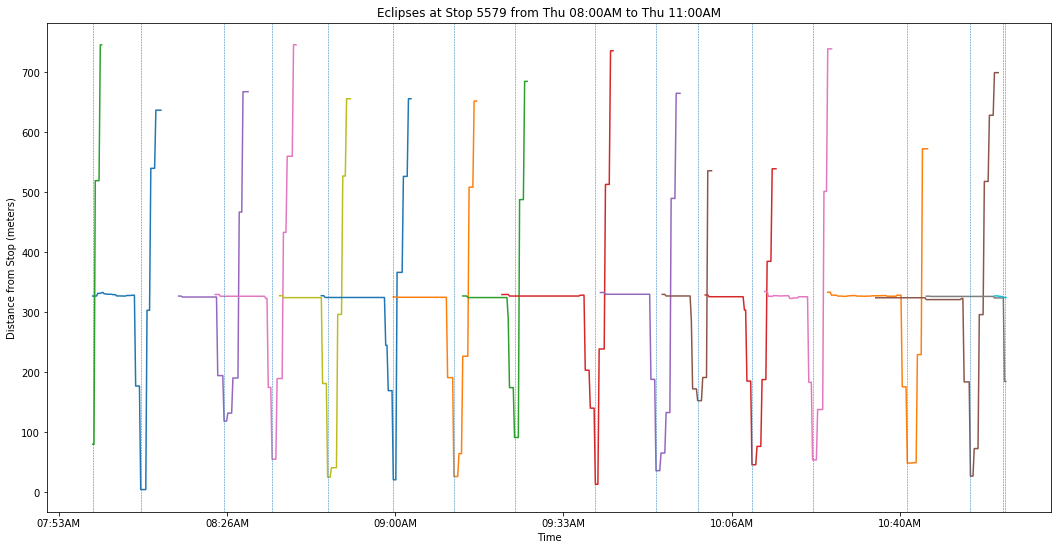

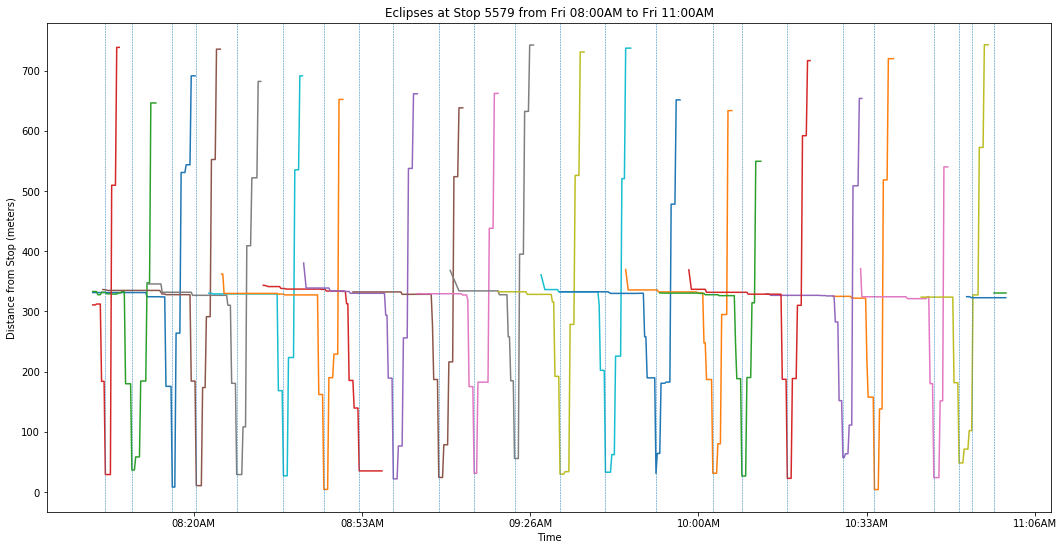

In [8]:
# grab an arbitrary stop to look at
stop_id = requests.get(f"http://restbus.info/api/agencies/sf-muni/routes/{route}").json()['stops'][2]['id']

bus_data = BusData()

for date in dates:
    start_time = int(datetime.strptime(f"{date} {timespan[0]}", "%Y-%m-%d %H:%M %Z").timestamp())*1000
    end_time   = int(datetime.strptime(f"{date} {timespan[1]}", "%Y-%m-%d %H:%M %Z").timestamp())*1000
    
    data = query_graphql(start_time, end_time, route)
    
    if data is None:  # API might refuse to cooperate
        print("API probably timed out")
        continue
    elif len(data) == 0:  # some days somehow have no data
        print(f"no data for {month}/{day}")
        continue
    else:
        stops = produce_stops(data)
        buses = produce_buses(data)

        stop = stops[stops['SID'] == stop_id].squeeze()
        buses = buses[buses['DID'] == stop['DID']]
        
        eclipses = find_eclipses(buses, stop)
        nadirs = find_nadirs(eclipses)
        
        show_stop(eclipses, nadirs)
        
        bus_data.append({
            route: {
                stop_id: {
                    'direction_id': stop['DID'],
                    'order': int(stop['ORD']),
                    'lat': stop['LAT'],
                    'lon': stop['LON'],
                    'eclipses': [
                        {
                            'bus_id': bus_id,
                            'timestamp': int(timestamp)
                        }
                        for bus_id, timestamp in zip(nadirs['VID'].tolist(),
                                                     nadirs['TIME'].tolist())
                    ]
                }
            }
        })
        
bus_data.write_file("bus_data.json")